# Model Classification of Convective Mode

In [1]:
import numpy as np
import pandas as pd
import glob

from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load the csv
df = pd.read_csv('/shared/shared/jcorner_data/pkls/data/images_1991_06.csv')
df

,Unnamed: 0,Index,x,y,Filename,Time
0,0,0,835,445,06011991_T01_0id.npy,1991-06-01T01:00:00.000000000
1,1,1,835,446,06011991_T01_1id.npy,1991-06-01T01:00:00.000000000
2,2,2,834,447,06011991_T01_2id.npy,1991-06-01T01:00:00.000000000
3,3,3,837,450,06011991_T01_3id.npy,1991-06-01T01:00:00.000000000
4,4,4,840,450,06011991_T01_4id.npy,1991-06-01T01:00:00.000000000
...,...,...,...,...,...,...
662,662,662,801,639,06301991_T22_662id.npy,1991-06-30T22:00:00.000000000
663,663,663,802,639,06301991_T22_663id.npy,1991-06-30T22:00:00.000000000
664,664,664,801,640,06301991_T22_664id.npy,1991-06-30T22:00:00.000000000
665,665,665,802,640,06301991_T22_665id.npy,1991-06-30T22:00:00.000000000


In [3]:
#find all files in the data directory
files = glob.glob('/home/jovyan/shared/jcorner_data/pkls/data/*.npy')
files.sort()
len(files)

612

In [9]:
#load the CNN model
model = keras.models.load_model("/home/jovyan/shared/jcorner_data/models/morph_model_v03.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 134, 134, 32)      320       
                                                                 
 spatial_dropout2d (SpatialD  (None, 134, 134, 32)     0         
 ropout2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 42, 42, 64)       0         
 lDropout2D)                                                     
                                                        

In [5]:
#create a list with the number corresponding to the convective mode.
lookup = {0:'isolated_cell', 1:'multiple_isolated_cells', 
          2:'loosely_clustered_cells', 3:'tightly_clustered_cells', 
          4:'qlcs', 5:'tropical'}

#create the new dataframe with the mode column
new_df = pd.DataFrame(columns=['Index', 'x', 'y', 'Filename', 'Time', 'Mode'])

#iterate through all the numpy files in the directory
for path in files:
    
    #isolate the filename from the path and dataframe
    filename = path[43:]
    row = df[(df['Filename']==filename)]

    #load the file
    file = np.load(path)

    if file.shape == (136, 136):
        
        #normalize the data
        file = file/80
    
        #expand the dimensions to the correct size
        file = np.expand_dims(file, 2)
        file = np.expand_dims(file, 0)
    
        #classify the convective mode using the CNN
        pred = model.predict(file)
        mode = [lookup[x] for x in np.argmax(pred, axis=1)]

        #append dataframe information to the dataframe
        new_df = new_df.append({'Index': row.Index.values[0], 'x': row.x.values[0], 'y':row.y.values[0], 'Filename': row.Filename.values[0], 'Time':row.Time.values[0], 'Mode': mode[0]}, ignore_index=True)

new_df

2023-07-12 15:50:54.833274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8500
2023-07-12 15:50:55.389045: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


,Index,x,y,Filename,Time,Mode
0,0,835,445,06011991_T01_0id.npy,1991-06-01T01:00:00.000000000,tropical
1,10,842,451,06011991_T01_10id.npy,1991-06-01T01:00:00.000000000,tropical
2,11,843,451,06011991_T01_11id.npy,1991-06-01T01:00:00.000000000,qlcs
3,12,840,452,06011991_T01_12id.npy,1991-06-01T01:00:00.000000000,tropical
4,13,841,452,06011991_T01_13id.npy,1991-06-01T01:00:00.000000000,tropical
...,...,...,...,...,...,...
587,662,801,639,06301991_T22_662id.npy,1991-06-30T22:00:00.000000000,qlcs
588,663,802,639,06301991_T22_663id.npy,1991-06-30T22:00:00.000000000,qlcs
589,664,801,640,06301991_T22_664id.npy,1991-06-30T22:00:00.000000000,qlcs
590,665,802,640,06301991_T22_665id.npy,1991-06-30T22:00:00.000000000,qlcs


In [8]:
#save the dataframe to a csv
new_df.to_csv('/shared/shared/jcorner_data/pkls/data/strom_modes__1991_06.csv')

## Check Model Predictions

<AxesSubplot:>

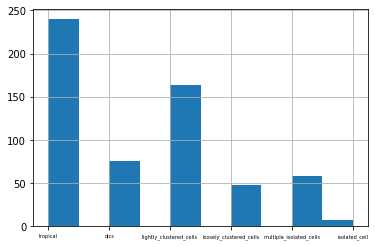

In [6]:
#create a histogram from the predictions
new_df.Mode.hist(xlabelsize = 5)

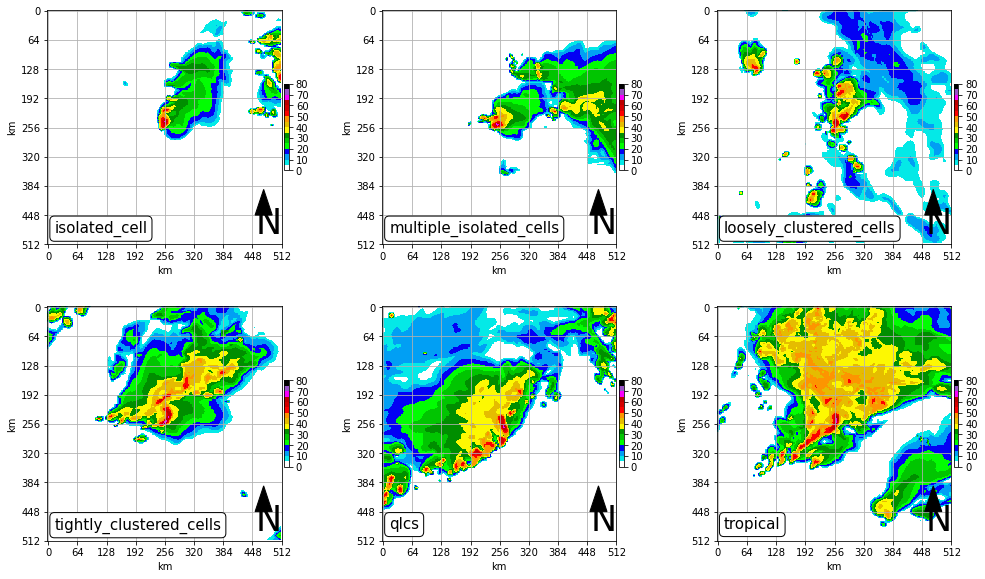

In [7]:
from svrimg.mapping.map_helper import radar_colormap, draw_box_plot
from matplotlib.colors import BoundaryNorm

#load a radarcolormap
cmap = radar_colormap()
classes = np.array(list(range(0, 85, 5)))
norm = BoundaryNorm(classes, ncolors=cmap.N)
plt.rcParams['figure.figsize'] = 17, 10

#iterate through each class
for i in range(6):
    ax = plt.subplot(2,3,i+1)

    #find a random image for each class and annotate the class
    sample = np.load(f"/home/jovyan/shared/jcorner_data/pkls/data/{new_df[(new_df['Mode'] == lookup[i])].sample()['Filename'].values[0]}")
    ax.annotate(f'{lookup[i]}', (0.03,0.05),fontsize=15, 
                        bbox=dict(boxstyle='round', facecolor='w', alpha=1), xycoords='axes fraction')

    #plot the data
    draw_box_plot(ax, sample.squeeze())